In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import random
from feature_extraction import extract_features_from_file_list, cvt_color, get_hog_features, bin_spatial, color_hist 
from config import feature_extraction_params
import pickle
import collections

In [2]:
def find_cars(img, y_start, y_stop, scale, svc, feature_scaler, params, verbose=False):
    hot_windows = []
    
    resize_h = params['resize_h']
    resize_w = params['resize_w']
    color_space = params['color_space']
    spatial_size = params['spatial_size']
    hist_bins = params['hist_bins']
    orient = params['orient']
    pix_per_cell = params['pix_per_cell']
    cell_per_block = params['cell_per_block']
    
    draw_img = np.copy(img)
    
    img_crop = img[y_start:y_stop, :, :]
    img_crop = cvt_color(img_crop, dest=color_space)
    
    if scale != 1:
        imgshape = img_crop.shape
        img_crop = cv2.resize(img_crop, 
                              (np.int(imgshape[1]/scale), np.int(imgshape[0]/scale)))
    
    ch1 = img_crop[:, :, 0]
    ch2 = img_crop[:, :, 1]
    ch3 = img_crop[:, :, 2]
    
    # define num of blocks and steps used in sliding windows
    n_x_blocks = (ch1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (ch1.shape[0] // pix_per_cell) - 1
    
    # sampling rate with 8 cells and 8 pixels per cell
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 4
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(n_x_steps):
        for yb in range(n_y_steps):
            y_pos = yb * cells_per_step
            x_pos = xb * cells_per_step
            
            # extract HOG for this patch
            hog_feature_1 = hog1[y_pos:y_pos+n_blocks_per_window, 
                                 x_pos:x_pos+n_blocks_per_window].ravel()
            
            hog_feature_2 = hog2[y_pos:y_pos+n_blocks_per_window, 
                                 x_pos:x_pos+n_blocks_per_window].ravel()
            
            hog_feature_3 = hog3[y_pos:y_pos+n_blocks_per_window, 
                                 x_pos:x_pos+n_blocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feature_1, hog_feature_2, hog_feature_3))
            
            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell
            
            # extract the image patch
            subimg = cv2.resize(img_crop[y_top:y_top+window, x_left:x_left+window], 
                                (resize_w, resize_h))
            
            # get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and make a prediction
            test_features = feature_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            )
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(x_left * scale)
                ytop_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                tl_corner_draw = np.array([xbox_left, ytop_draw + y_start])
                br_corner_draw = tl_corner_draw + win_draw
                
                cv2.rectangle(draw_img, tuple(tl_corner_draw), tuple(br_corner_draw), (0, 0, 255), 6)
                
                hot_windows.append((tuple(tl_corner_draw), tuple(br_corner_draw)))
            
                if verbose:
                    plt.figure()
                    plt.imshow(draw_img)
                    plt.show()
                
    return hot_windows

### Lets find some cars

/home/jameschien/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


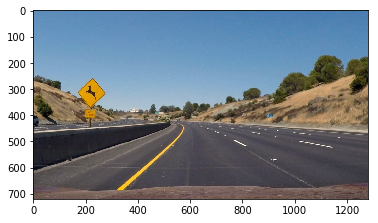

In [3]:
sample_images_dir = 'test_images'
sample_images = [mpimg.imread(p) for p in glob.glob(os.path.join('../', sample_images_dir, '*.jpg'))]
sample_images_features = extract_features_from_file_list(sample_images, feature_extraction_params)

plt.imshow(sample_images[random.randint(0, len(sample_images)-1)])

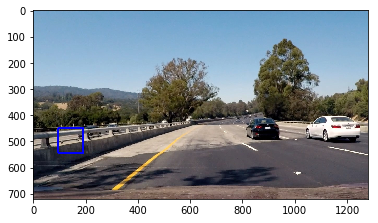

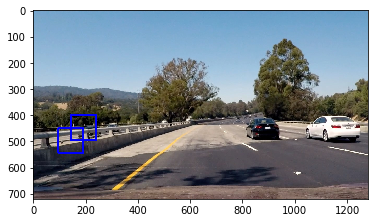

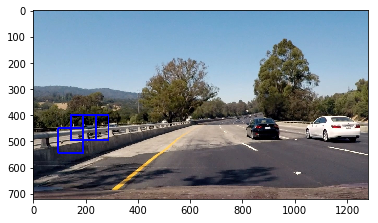

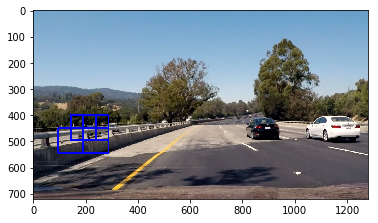

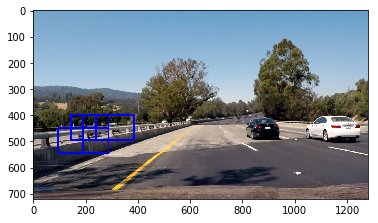

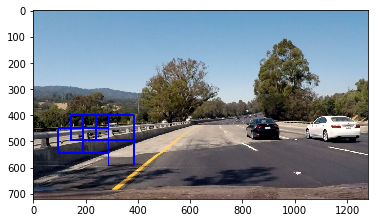

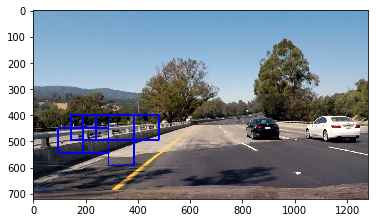

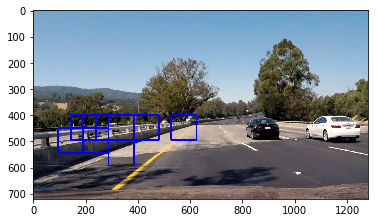

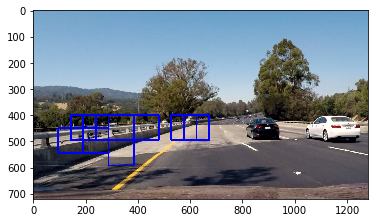

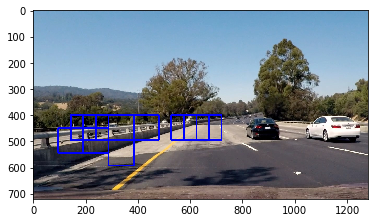

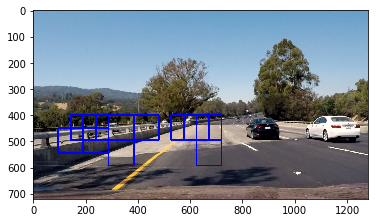

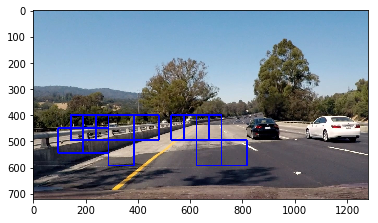

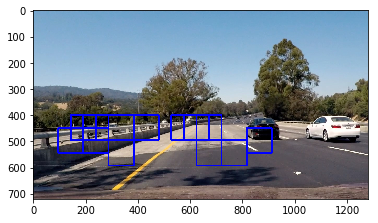

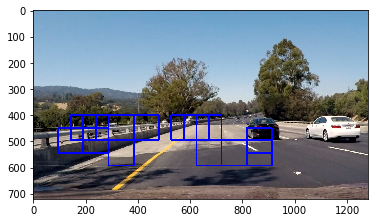

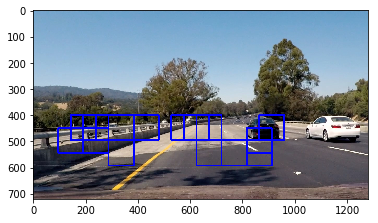

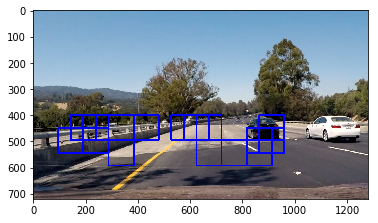

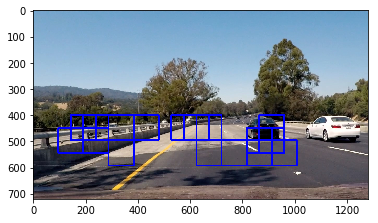

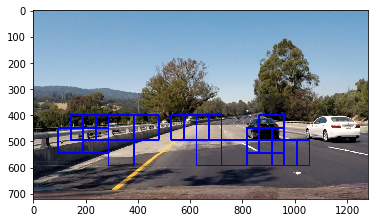

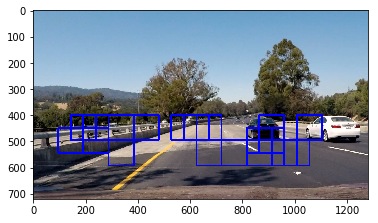

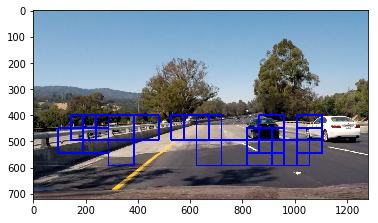

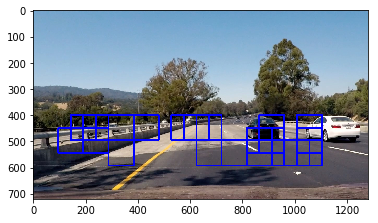

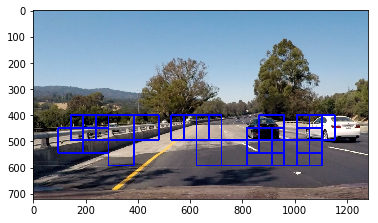

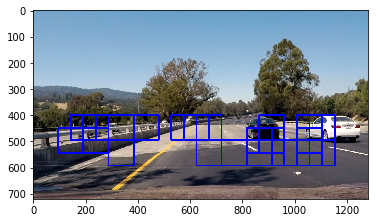

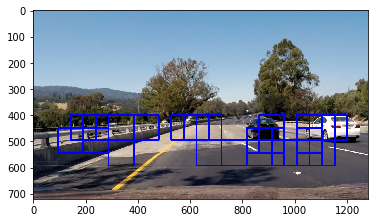

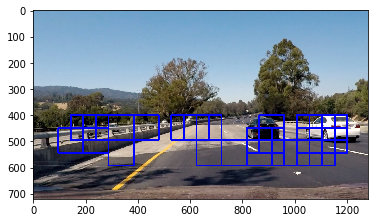

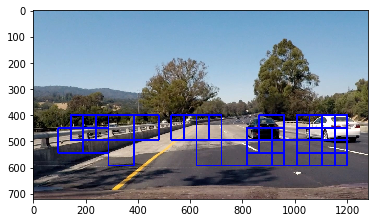

In [12]:
svc = pickle.load(open('weights/svc_car.pickle', 'rb'))
feature_scaler = pickle.load(open('weights/feature_scaler.pickle', 'rb'))

ystart = 400
ystop = 656
scale = 1.5
_ = find_cars(sample_images[0], ystart, ystop, scale,
                             svc, feature_scaler, feature_extraction_params, verbose=True)

